In [4]:
import odl
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

In [25]:
def get_images(path, amount_of_images='all', scale_number=1):

    all_images = []
    all_image_names = os.listdir(path)
    print(len(all_image_names))
    if amount_of_images == 'all':
        for name in all_image_names:
            # print(path + '\\' + name)
            temp_image = cv.imread(path + '\\' + name, cv.IMREAD_UNCHANGED)
            image = temp_image[80:420, 80:420]
            image = image[0:340:scale_number, 0:340:scale_number]
            image = image / 0.07584485627272729
            all_images.append(image)
    else:
        temp_indexing = np.random.permutation(len(all_image_names))[:amount_of_images]
        images_to_take = [all_image_names[i] for i in temp_indexing]
        for name in images_to_take:
            temp_image = cv.imread(path + '/' + name, cv.IMREAD_UNCHANGED)
            image = temp_image[90:410, 90:410]
            image = image[0:320:scale_number, 0:320:scale_number]
            image = image / 0.07584485627272729
            all_images.append(image)

    return all_images

### Here one loads the image which is used in these classical algorithms. 

### Define your own path to the image.
path = r'C:\Users\antti\Documents\Koodit\noise2inverse\walnuts'
print(path)


images = get_images(path, amount_of_images='all', scale_number=1)
print(np.shape(images))
# ### Load the image.
# image = cv.imread(path, cv.IMREAD_UNCHANGED)
# image = image[90:410, 90:410]
# # image = image[0:320:factor, 0:320:factor]

# ### Normalizing the image and taking its shape.
# image = image / np.max(np.max(image))
shape = np.shape(images[0])

C:\Users\antti\Documents\Koodit\noise2inverse\walnuts
37
(37, 340, 340)


In [68]:
### There is couple of parameters:

### What kind measurement environment one wants to choose.
### Possible options are 'full', 'sparse', 'limited'.
setup = 'full'

### Factor down amount of the detection lines, must be int.
factor_lines = 1

### Radius from the source to object.
source_radius = 2

### Radius from the object to detector.
detector_radius = 1

if setup == 'full':
    angles = odl.uniform_partition(0, 2*np.pi, 720)
    lines = odl.uniform_partition(-np.pi, np.pi, int(1024/factor_lines))
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)
    output_shape = (360, int(1024/factor_lines))
elif setup == 'sparse':
    angle_measurements = 50
    line_measurements = int(1024/factor_lines)
    angles = odl.uniform_partition(0, 2*np.pi, angle_measurements)
    lines = odl.uniform_partition(-1*np.pi, np.pi, line_measurements)
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)
elif setup == 'limited':
    starting_angle = 0
    final_angle = np.pi * 1/2
    angles = odl.uniform_partition(starting_angle, final_angle, 360)
    lines = odl.uniform_partition(-1*np.pi, np.pi, int(1024/factor_lines))
    geometry = odl.tomo.FanBeamGeometry(angles, lines, source_radius, detector_radius)


### The domain is defined here, there is couple of parameters:

### Imagine a box in 2D-plane with this parameter being the most southwest point of the box.
min_domain_corner = [-1,-1]

### Imagine a box in 2D-plane with this parameter being the most northeast point of the box.
max_domain_corner = [1,1]

### Number of samples per axis.
shape = shape

### Data type 
dtype = 'float'

domain = odl.uniform_discr(min_domain_corner, max_domain_corner, shape=shape, dtype=dtype)

### The ray transform is defined here

device = 'astra_cuda'

ray_transform = odl.tomo.RayTransform(domain, geometry, impl=device)
print(domain)
print(ray_transform.range)

uniform_discr([-1., -1.], [ 1.,  1.], (340, 340))
uniform_discr(
    [ 0.        , -3.14159265], [ 6.28318531,  3.14159265],
    (720, 1024)
)


In [69]:
### First convert image into ODL form
image1 = domain.element(images[20])

### Use ray transform to the image to obtain sinogram
sinogram = ray_transform(image1)

### Parameters for the Gaussian noise
mean = 0.0
variance = 0.002
sigma = variance ** 0.5

### Create noisy sinogram
noisy_sinogram = sinogram + np.random.normal(mean, sigma, size=(np.shape(sinogram)[0], np.shape(sinogram)[1]))
noisy_sinogram = np.maximum(noisy_sinogram,0)

# print(sinogram.T(odl.IdentityOperator(np.shape(sinogram))))

# fig, axs = plt.subplots(1, 3, squeeze=False)
# fig.suptitle('Hmm')
# axs[0, 0].imshow(image1)
# axs[0, 1].imshow(sinogram)
# axs[0, 2].imshow(noisy_sinogram)

# plt.figure()
# plt.subplot(1,3,1)
# plt.imshow(image1)
# # image1.show('Ground truth')
# plt.subplot(1,3,2)
# plt.imshow(sinogram)
# # sinogram.show('Clear sinogram')
# plt.subplot(1,3,3)
# plt.imshow(noisy_sinogram)
# # noisy_sinogram.show('Noisy sinogram')
# plt.show()

(720, 1024)
torch.Size([10, 72, 1024])
torch.Size([10, 72, 1024])
fbp uniform_discr([-1., -1.], [ 1.,  1.], (340, 340))


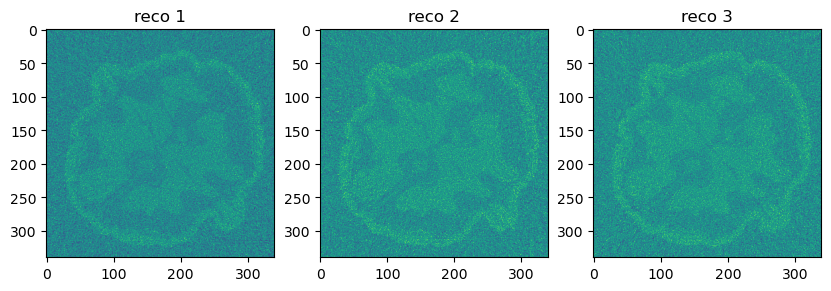

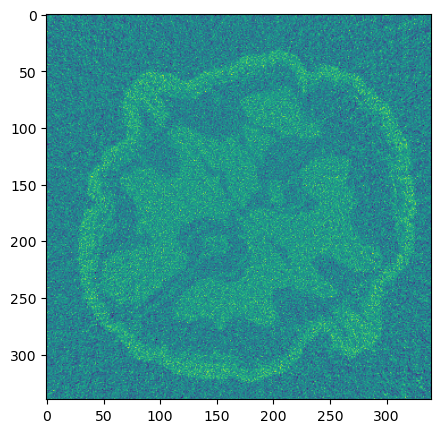

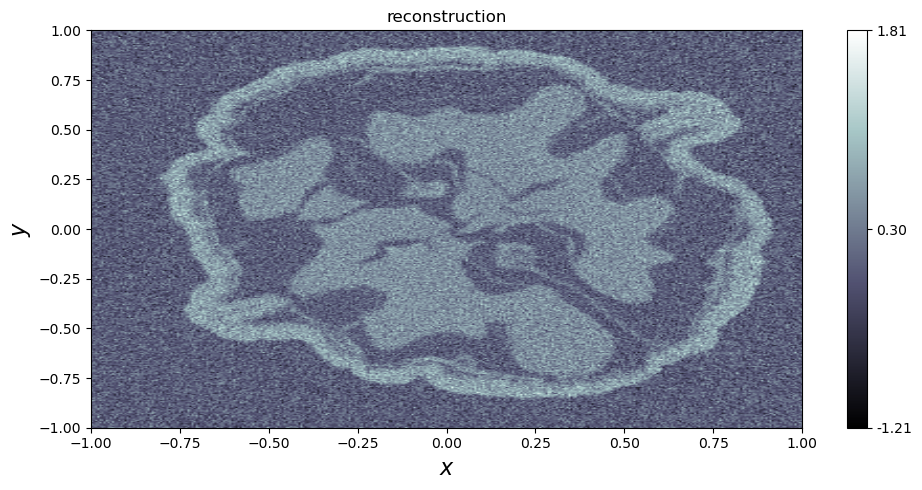

<Figure size 1000x500 with 0 Axes>

In [71]:
from odl.contrib.torch import OperatorModule
num_of_splits = 10
print(noisy_sinogram.shape)
# noisy_sinograms = torch.zeros((sinograms.shape[0], ) + output_shape)
sinogram_split = torch.zeros((num_of_splits, ) + (int(noisy_sinogram.shape[0]/num_of_splits), noisy_sinogram.shape[1]))
print(sinogram_split.shape)
# split_geom = np.zeros((num_of_splits, output_shape[0], int(np.ceil(output_shape[1]/num_of_splits))))
for j in range(num_of_splits):
    # print(j)
    # split_geom[j,:,:] = geometry[j::num_of_splits]
    split = geometry[j::num_of_splits]
    # split_domain = domain[j::num_of_splits]
    sinogram_splits = noisy_sinogram[j::num_of_splits, :]
    # sinogram_splits.show('hmm')
    # plt.show()
    # print(sinogram_splits.shape)
    # print(type(sinogram_splits))
    sinogram_split[j,:,:] = torch.as_tensor(noisy_sinogram[j::num_of_splits, :])
    operator_split = odl.tomo.RayTransform(domain, split, impl=device)

# sinogram_split = domain.element(sinogram_split)
print(sinogram_split.shape)
# sinogram_split.show('asd')
# plt.show()
# print(domain)
# print('geom', geometry)
# print('split',split)
# print('ray',ray_transform.range)
# print('split_op',operator_split.range)
split_FBP = odl.tomo.analytic.filtered_back_projection.fbp_op(operator_split, padding=1)
# print('asd')
fbp_operator_module = OperatorModule(split_FBP).to('cuda')
print('fbp',split_FBP.range)
split_reco = torch.zeros((num_of_splits, ) + (shape))
split_reco = fbp_operator_module(sinogram_split)
# for k in range(num_of_splits):
#     split_reco[k,:,:] = split_FBP(sinogram_split[k,:,:]).cpu().detach().numpy()

# print(domain)

# split_reco = domain.element(split_reco)

plt.figure()
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1,3,1)
plt.imshow(split_reco[0,:,:].cpu().detach().numpy())
plt.gca().set_title('reco 1')
plt.subplot(1,3,2)
plt.imshow(split_reco[1,:,:].cpu().detach().numpy())
plt.gca().set_title('reco 2')
plt.subplot(1,3,3)
plt.imshow(split_reco[2,:,:].cpu().detach().numpy())
plt.gca().set_title('reco 3')
plt.show()

input_reco = np.zeros(shape)
for k in range(num_of_splits-7):
    input_reco = input_reco + split_reco[k,:,:].cpu().detach().numpy()

input_reco = input_reco / (num_of_splits-7)

plt.figure()
plt.imshow(input_reco)
plt.show()



# plt.figure()
# split_reco[0,:,:].cpu().detach().numpy().show('asd')
# split_reco[1,:,:].cpu().detach().numpy().show()
# plt.show()

### There is function in ODL to create FBP operator:
FBP_operator = odl.tomo.analytic.filtered_back_projection.fbp_op(ray_trafo=ray_transform, padding=1)

### One just applies the noisy sinogram with just defined FBP operator and gets a reconstruction out.
reconstruction = FBP_operator(noisy_sinogram)

### Because in these sections the images are plotted in ODL domain the next thing is needed:
reconstruction = domain.element(reconstruction)

### Plotting the reconstructed image
reconstruction.show('reconstruction')
plt.show()